In [1]:
import numpy as np
import pandas as pd
import requests as rq

from plotnine import *

In [2]:
with open('eia_api_key.txt') as f:
    API_KEY = f.readline()

In [4]:
## hourly EIA generation API URL
## series description: Hourly net generation by balancing authority and energy source. Source: Form EIA-930 Product: Hourly Electric Grid Monitor
## URL: https://www.eia.gov/opendata/browser/electricity/rto/fuel-type-data?frequency=local-hourly&data=value;&facets=respondent;&respondent=SOCO;&start=2024-03-01T00:00:00-05:00&sortColumn=period;&sortDirection=desc;

api_url = f"https://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?frequency=local-hourly&data[0]=value&facets[respondent][]=SOCO&start=2024-02-21T00:00:00-05:00&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={API_KEY}"
hourly_gen = rq.get(api_url)
type(hourly_gen)

requests.models.Response

In [5]:
hourly_json_data = hourly_gen.json()
type(hourly_json_data)

dict

In [6]:
hourly_json_keys = list(hourly_json_data.keys())
print(len(hourly_json_keys))
hourly_json_keys

4


['response', 'request', 'apiVersion', 'ExcelAddInVersion']

In [7]:
power_df = pd.DataFrame(hourly_json_data['response']['data'])
power_df['hour'] = pd.to_datetime(power_df['period'], format = '%Y-%m-%dT%H-%M')
power_df['value'] = pd.to_numeric(power_df['value'])
print(power_df.shape)
power_df.query('fueltype == "SUN"').head(10)

(2936, 8)


,period,respondent,respondent-name,fueltype,type-name,value,value-units,hour
6,2024-03-07T00-06,SOCO,"Southern Company Services, Inc. - Trans",SUN,Solar,-2,megawatthours,2024-03-07 00:06:00
12,2024-03-06T23-06,SOCO,"Southern Company Services, Inc. - Trans",SUN,Solar,-1,megawatthours,2024-03-06 23:06:00
16,2024-03-06T22-06,SOCO,"Southern Company Services, Inc. - Trans",SUN,Solar,-1,megawatthours,2024-03-06 22:06:00
24,2024-03-06T21-06,SOCO,"Southern Company Services, Inc. - Trans",SUN,Solar,0,megawatthours,2024-03-06 21:06:00
38,2024-03-06T20-06,SOCO,"Southern Company Services, Inc. - Trans",SUN,Solar,-1,megawatthours,2024-03-06 20:06:00
45,2024-03-06T19-06,SOCO,"Southern Company Services, Inc. - Trans",SUN,Solar,-1,megawatthours,2024-03-06 19:06:00
48,2024-03-06T18-06,SOCO,"Southern Company Services, Inc. - Trans",SUN,Solar,74,megawatthours,2024-03-06 18:06:00
63,2024-03-06T17-06,SOCO,"Southern Company Services, Inc. - Trans",SUN,Solar,653,megawatthours,2024-03-06 17:06:00
64,2024-03-06T16-06,SOCO,"Southern Company Services, Inc. - Trans",SUN,Solar,916,megawatthours,2024-03-06 16:06:00
74,2024-03-06T15-06,SOCO,"Southern Company Services, Inc. - Trans",SUN,Solar,1063,megawatthours,2024-03-06 15:06:00


In [12]:
def get_series_label_df(df, x, label):
    label_df = df.sort_values(x, ascending = True).groupby(label).tail(1)
    return label_df

get_series_label_df(power_df, x = 'hour', label = 'fueltype')

,period,respondent,respondent-name,fueltype,type-name,value,value-units,hour
7,2024-03-07T00-06,SOCO,"Southern Company Services, Inc. - Trans",COL,Coal,3357,megawatthours,2024-03-07 00:06:00
6,2024-03-07T00-06,SOCO,"Southern Company Services, Inc. - Trans",SUN,Solar,-2,megawatthours,2024-03-07 00:06:00
5,2024-03-07T00-06,SOCO,"Southern Company Services, Inc. - Trans",OTH,Other,61,megawatthours,2024-03-07 00:06:00
4,2024-03-07T00-06,SOCO,"Southern Company Services, Inc. - Trans",OIL,Petroleum,-1,megawatthours,2024-03-07 00:06:00
3,2024-03-07T00-06,SOCO,"Southern Company Services, Inc. - Trans",WND,Wind,0,megawatthours,2024-03-07 00:06:00
2,2024-03-07T00-06,SOCO,"Southern Company Services, Inc. - Trans",NUC,Nuclear,6160,megawatthours,2024-03-07 00:06:00
1,2024-03-07T00-06,SOCO,"Southern Company Services, Inc. - Trans",NG,Natural gas,9431,megawatthours,2024-03-07 00:06:00
0,2024-03-07T00-06,SOCO,"Southern Company Services, Inc. - Trans",WAT,Hydro,1276,megawatthours,2024-03-07 00:06:00


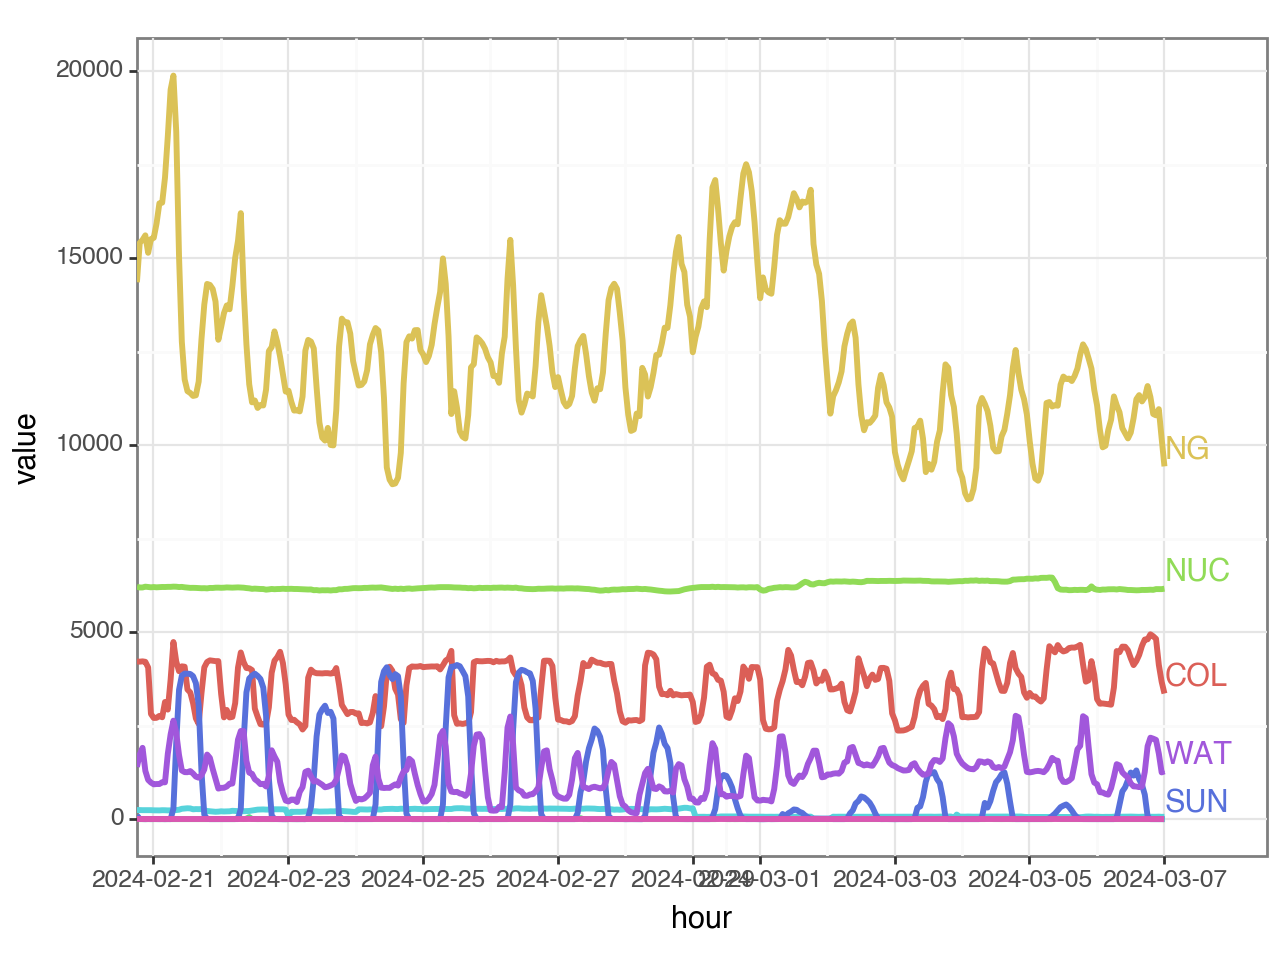

<Figure Size: (640 x 480)>

In [28]:
(ggplot(power_df, aes(x = 'hour', y = 'value', color = 'fueltype')) + 
 geom_line(size = 1.2) +
 geom_text(get_series_label_df(power_df.loc[power_df['fueltype'].isin(['COL', 'NG', 'NUC', 'COL', 'WAT', 'SUN'])], x = 'hour', label = 'fueltype'),
           aes(label = 'fueltype'), ha = 'left', va = 'bottom') +
 theme_bw() +
 scale_x_datetime(expand = (0, 0, .1, 0)) +
 theme(legend_position = 'none')
)